<a href="https://colab.research.google.com/github/KaziMinhaj/anaconda/blob/main/Skin_Cancer_Classification(vgg16_and_vgg19%2C_efficient_net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
skin_df = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')

In [ ]:
skin_df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp


In [ ]:
# one hot encoding and fitting
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# transforming the encoded version and creating a new column "label" for it
skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


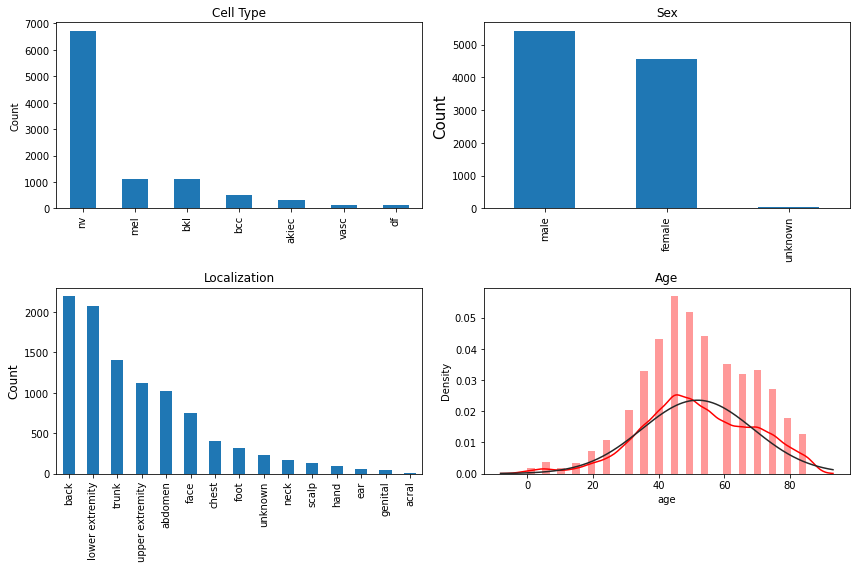

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [ ]:
#Applying Augmentation to balance the dataset
n_samples=1500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [ ]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

6    1500
5    1500
4    1500
3    1500
2    1500
1    1500
0    1500
Name: label, dtype: int64


In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
SIZE = 128
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/archive', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images/JPG files.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

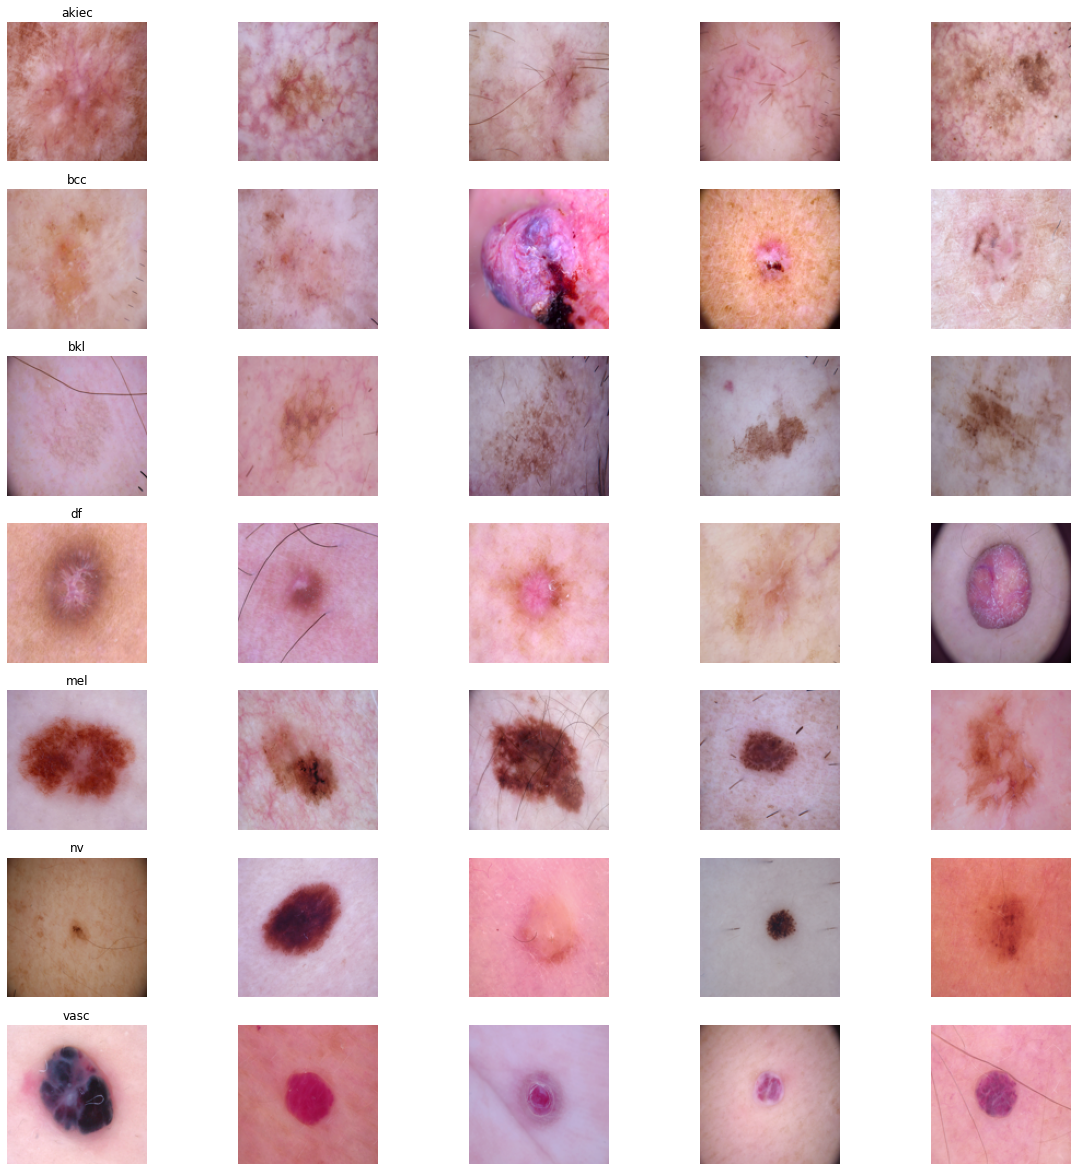

In [ ]:
n_samples = 5  

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # normalizing to scale values to 0-1. 
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)
x_valid, x_valid, y_valid, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

Transfer Learning(VGG19)

In [ ]:
IMAGE_SIZE = [64, 64]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(7, activation='softmax')(x)

In [ ]:
# create a model object
from keras.models import Model
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision())

In [ ]:
batch_size = 16 
epochs = 75

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_valid, y_valid),verbose=2)

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Validation accuracy:', score[1])

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
score = model.evaluate(x_test, y_test)
print('Testing accuracy:', score[1])

precision = sklearn.metrics.precision_score(y_test, y_pred, pos_label="positive")

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '#fc7348', label='Training loss')
plt.plot(epochs, val_loss, '#01d145', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, '#fc7348', label='Training acc')
plt.plot(epochs, val_acc, '#01d145', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

VGG16

In [ ]:
IMAGE_SIZE = [64, 64]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(7, activation='softmax')(x)

In [ ]:
# create a model object
from keras.models import Model
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision())

In [ ]:
batch_size = 16 
epochs = 50

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_valid, y_valid),verbose=2)

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Validation accuracy:', score[1])

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
score = model.evaluate(x_test, y_test)
print('Testing accuracy:', score[1])

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '#001379', label='Training loss')
plt.plot(epochs, val_loss, '#fd62a1', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, '#001379', label='Training acc')
plt.plot(epochs, val_acc, '#fd62a1', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

EffecientNetb7

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
#X = X/255.  # normalizing to scale values to 0-1. 
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)
x_valid, x_valid, y_valid, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [ ]:
ef=tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(64,64,3),
    pooling=max,
    classes=7,
    classifier_activation="softmax",
    
)

In [ ]:
for layer in ef.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(ef.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(7, activation='softmax')(x)

In [ ]:
# create a model object
from keras.models import Model
model = Model(inputs=ef.input, outputs=prediction)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision())

In [ ]:
batch_size = 16 
epochs = 50

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_valid, y_valid),verbose=2)

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Validation accuracy:', score[1])

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
score = model.evaluate(x_test, y_test)
print('Testing accuracy:', score[1])

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, '#01d145', label='Training loss')
plt.plot(epochs, val_loss, '#9300ff', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, '#01d145', label='Training acc')
plt.plot(epochs, val_acc, '#9300ff', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()